# GSD: Rpb1 orthologs in 1011 genomes collection

This collects Rpb1 gene and protein sequences from a collection of natural isolates of sequenced yeast genomes from [Peter et al 2017](https://www.ncbi.nlm.nih.gov/pubmed/29643504), and then estimates the count of the heptad repeats. It builds directly on the notebook [here](GSD%20Rpb1_orthologs_in_PB_genomes.ipynb), which descends from [Searching for coding sequences in genomes using BLAST and Python](../Searching%20for%20coding%20sequences%20in%20genomes%20using%20BLAST%20and%20Python.ipynb). It also builds on the notebooks shown [here](https://nbviewer.jupyter.org/github/fomightez/cl_sq_demo-binder/blob/master/notebooks/GSD/GSD%20Add_Supplemental_data_info_to_nt_count%20data%20for%201011_cerevisiae_collection.ipynb) and [here](https://github.com/fomightez/patmatch-binder). 

Reference for sequence data:  
[Genome evolution across 1,011 Saccharomyces cerevisiae isolates. Peter J, De Chiara M, Friedrich A, Yue JX, Pflieger D, Bergström A, Sigwalt A, Barre B, Freel K, Llored A, Cruaud C, Labadie K, Aury JM, Istace B, Lebrigand K, Barbry P, Engelen S, Lemainque A, Wincker P, Liti G, Schacherer J. Nature. 2018 Apr;556(7701):339-344. doi: 10.1038/s41586-018-0030-5. Epub 2018 Apr 11. PMID: 29643504](https://www.ncbi.nlm.nih.gov/pubmed/29643504)

  
  -----

## Overview
![overview of steps](../../imgs/ortholog_mining_summarized.png)

## Preparation

Get scripts and sequence data necessary.

**DO NOT 'RUN ALL'. AN INTERACTION IS NECESSARY AT CELL FIVE. AFTER THAT INTERACTION, THE REST BELOW IT CAN BE RUN.**

(Caveat: right now this is written for genes with no introns. Only a few hundred have in yeast and that is the organism in this example. Intron presence would only become important when trying to translate in late stages of this workflow.)

In [1]:
gene_name = "RPB1"
size_expected = 5202
get_seq_from_link = False
link_to_FASTA_of_gene = "https://gist.githubusercontent.com/fomightez/f46b0624f1d8e3abb6ff908fc447e63b/raw/625eaba76bb54e16032f90c8812350441b753a0c/uz_S288C_YOR270C_VPH1_coding.fsa"
#**Possible future enhancement would be to add getting the FASTA of the gene from Yeastmine with just systematic id**

Get the `blast_to_df` script by running this commands.

In [2]:
import os
file_needed = "blast_to_df.py"
if not os.path.isfile(file_needed):
    !curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/blast-utilities/blast_to_df.py
import pandas as pd

**Now to get the entire collection or a subset of the 1011 genomes, the next cell will need to be edited.** I'll probably leave it with a small set for typical running purposes. However, to make it run fast, try the 'super-tiny' set with just two.

In [3]:
# Method to get ALL the genomes. TAKES A WHILE!!! 
# (ca. 1 hour and 15 minutes to download alone? + Extracting is a while.)
# Easiest way to minotor extracting step is to open terminal, cd to 
# `GENOMES_ASSEMBLED`, & use `ls | wc -l` to count files extracted.
#!curl -O http://1002genomes.u-strasbg.fr/files/1011Assemblies.tar.gz
#!tar xzf 1011Assemblies.tar.gz
#!rm 1011Assemblies.tar.gz

# Small development set
!curl -OL https://www.dropbox.com/s/f42tiygq9tr1545/medium_setGENOMES_ASSEMBLED.tar.gz
!tar xzf medium_setGENOMES_ASSEMBLED.tar.gz

# Tiny development set
#!curl -OL https://www.dropbox.com/s/txufq2jflkgip82/tiny_setGENOMES_ASSEMBLED.tar.gz
#!tar xzf tiny_setGENOMES_ASSEMBLED.tar.gz
#!mv tiny_setGENOMES_ASSEMBLED GENOMES_ASSEMBLED

#define directory with genomes
genomes_dirn = "GENOMES_ASSEMBLED"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    819      0 --:--:--  0:00:01 --:--:--     0
100  183M  100  183M    0     0  23.6M      0  0:00:07  0:00:07 --:--:-- 52.4M


Before process the list of all of them, fix one that has an file name mismatch with what the description lines have.  
Specifically, the assembly file name is `CDH.re.fa`, but the FASTA-entries inside begin `CDH-3`.  
Simple file name mismatch.  So next cell will change that file name to match.  

In [19]:
import os
import sys
file_with_issues = "CDH.re.fa"
if os.path.isfile("GENOMES_ASSEMBLED/"+file_with_issues):
    sys.stderr.write("\nFile with name non-matching entries ('{}') observed and"
        " fixed.".format(file_with_issues))
    !mv GENOMES_ASSEMBLED/CDH.re.fa GENOMES_ASSEMBLED/CDH_3.re.fa
    #pause and then check if file with original name is there still because
    # it means this was attempted too soon and need to start over.
    import time
    time.sleep(12) #12 seconds 
    if os.path.isfile("GENOMES_ASSEMBLED/"+file_with_issues):
        sys.stderr.write("\n***PROBLEM. TRIED THIS CELL BEFORE FINISHED UPLOADING.\n"
            "DELETE FILES ASSOCIATED AND START ALL OVER AGAIN WITH UPLOAD STEP***.")
else:
    sys.stderr.write("\nFile '{}' not seen and so nothing done"
        ". Seems wrong.".format(file_with_issues))
    sys.exit(1)


File with name non-matching entries ('CDH.re.fa') observed and fixed.

In [8]:
# Get SGD gene sequence in FASTA format to search for best matches in the genomes
import sys
gene_filen = gene_name + ".fsa"
if get_seq_from_link:
    !curl -o {gene_filen} {link_to_FASTA_of_gene}
else:
    !touch {gene_filen}
    sys.stderr.write("\nEDIT THE FILE '{}' TO CONTAIN "
        "YOUR GENE OF INTEREST (FASTA-FORMATTED)"
        ".".format(gene_filen))
    sys.exit(0)


EDIT THE FILE 'RPB1.fsa' TO CONTAIN YOUR GENE OF INTEREST (FASTA-FORMATTED).

SystemExit: 0

**I PUT CONTENTS OF FILE `S288C_YDL140C_RPO21_coding.fsa` downloaded from [here](https://www.yeastgenome.org/locus/S000002299/sequence) as 'RPB1.fsa'.**

Now you are prepared to run BLAST to search each PacBio-sequenced genomes for the best match to a gene from the Saccharomyces cerevisiae strain S288C reference sequence.

## Use BLAST to search the genomes for matches to the gene in the reference genome at SGD

SGD is the [Saccharomyces cerevisiae Genome Database site](http:yeastgenome.org) and the reference genome is from S288C.

This is going to go through each genome and make a database so it is searchable and then search for matches to the gene. The information on the best match will be collected. One use for that information will be collecting the corresponding sequences later.

Import the script that allows sending BLAST output to Python dataframes so that we can use it here.

In [20]:
from blast_to_df import blast_to_df

In [21]:
# Make a list of all `genome.fa` files, excluding `genome.fa.nhr` and `genome.fa.nin` and `genome.fansq`
# The excluding was only necessary because I had run some queries preliminarily in development. Normally, it would just be the `.re.fa` at the outset.
fn_to_check = "re.fa" 
genomes = []
import os
import fnmatch
for file in os.listdir(genomes_dirn):
    if fnmatch.fnmatch(file, '*'+fn_to_check):
        if not file.endswith(".nhr") and not file.endswith(".nin") and not file.endswith(".nsq") :
            # plus skip hidden files
            if not file.startswith("._"):
                genomes.append(file)
len(genomes)

48

Using the trick of putting `%%capture` on first line from [here](https://stackoverflow.com/a/23692951/8508004) to suppress the output from BLAST for many sequences from filling up cell.  
(You can monitor the making of files ending in `.nhr` for all the FASTA files in `GENOMES_ASSEMBLED` to monitor progress'.)

In [22]:
%%time
%%capture
SGD_gene = gene_filen
dfs = []
for genome in genomes:
    !makeblastdb -in {genomes_dirn}/{genome} -dbtype nucl
    result = !blastn -query {SGD_gene} -db {genomes_dirn}/{genome} -outfmt "6 qseqid sseqid stitle pident qcovs length mismatch gapopen qstart qend sstart send qframe sframe frames evalue bitscore qseq sseq" -task blastn
    from blast_to_df import blast_to_df
    blast_df = blast_to_df(result.n)
    dfs.append(blast_df.head(1))

CPU times: user 1.74 s, sys: 1.22 s, total: 2.97 s
Wall time: 1min 21s


In [23]:
# merge the dataframes in the list `dfs` into one dataframe
df = pd.concat(dfs)

In [24]:
#Save the df
filen_prefix = gene_name + "_orthologBLASTdf"
df.to_pickle(filen_prefix+".pkl")
df.to_csv(filen_prefix+'.tsv', sep='\t',index = False) 

In [25]:
#df

Computationally check if any genomes missing from the BLAST results list?

In [26]:
subjids = df.sseqid.tolist()
#print (subjids)
#print (subjids[0:10])
subjids = [x.split("-")[0] for x in subjids]
#print (subjids)
#print (subjids[0:10])
len_genome_fn_end = len(fn_to_check) + 1 # plus one to accound for the period that will be 
# between `fn_to_check` and strain_id`, such as `SK1.genome.fa`
genome_ids = [x[:-len_genome_fn_end] for x in genomes]
#print (genome_ids[0:10])

a = set(genome_ids)
#print (a)
print ("initial:",len(a))
r = set(subjids)
print("results:",len(r))
print ("missing:",len(a-r))
if len(a-r):
    print("\n")
    print("ids missing:",a-r)
#a - r

initial: 48
results: 48
missing: 0


Sanity check: Report on how expected size compares to max size seen?

In [28]:
size_seen = df.length.max(0)
print ("Expected size of gene:", size_expected)
print ("Most frequent size of matches:", df.length.mode()[0])
print ("Maximum size of matches:", df.length.max(0))

Expected size of gene: 5202
Most frequent size of matches: 5202
Maximum size of matches: 5306


## Collect the identified, raw sequences

Get the expected size centered on the best match, plus a little flanking each because they might not exactly cover the entire open reading frame. (Although, the example here all look to be full size.)

In [29]:
# Get the script for extracting based on position (and install dependency pyfaidx)
import os
file_needed = "extract_subsequence_from_FASTA.py"
if not os.path.isfile(file_needed):
    !curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/Extract_from_FASTA/extract_subsequence_from_FASTA.py
!pip install pyfaidx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16964  100 16964    0     0  74078      0 --:--:-- --:--:-- --:--:-- 74078


For the next cell, I am going to use the trick of putting `%%capture` on first line from [here](https://stackoverflow.com/a/23692951/8508004) to suppress the output from the entire set making a long list of output.
For ease just monitor the progress in a launched terminal with the following code run in the directory where this notebook will be because the generated files only moved into the `raw` directory as last step of cell:

    ls seq_extracted* | wc -l
    
(**NOTE: WHEN RUNNING WITH THE FULL SET, THIS CELL BELOW WILL REPORT AROUND A DOZEN `FileNotFoundError:`/Exceptions. HOWEVER, THEY DON'T CAUSE THE NOTEBOOK ITSELF TO CEASE TO RUN. SO DISREGARD THEM FOR THE TIME BEING.** )

In [30]:
%%capture
size_expected = size_expected # use value from above, or alter at this point.
#size_expected = df.length.max(0) #bp length of SGD coding sequence; should be equivalent and that way not hardcoded?
extra_add_to_start = 51 #to allow for 'fuzziness' at starting end
extra_add_to_end = 51 #to allow for 'fuzziness' at far end
genome_fn_end = "re.fa" 


def midpoint(items):
    '''
    takes a iterable of items and returns the midpoint (integer) of the first 
    and second values
    '''
    return int((int(items[0])+int(items[1]))/2)

#midpoint((1,100))

def determine_pos_to_get(match_start,match_end):
    '''
    Take the start and end of the matched region.
    
    Calculate midpoint between those and then 
    center expected size on that to determine
    preliminary start and preliminary end to get.
    Add the extra basepairs to get at each end
    to allow for fuzziness/differences of actual
    gene ends for orthologs. 
    Return the final start and end positions to get.
    
    '''
    center_of_match = midpoint((match_start,match_end))
    half_size_expected = int(size_expected/2.0)
    if size_expected % 2 != 0:
        half_size_expected += 1
    start_pos = center_of_match - half_size_expected
    end_pos = center_of_match + half_size_expected
    start_pos -= extra_add_to_start
    end_pos += extra_add_to_end 
    
    # Because of getting some flanking sequences to account for 'fuzziness', it 
    # is possible the start and end can exceed possible. 'End' is not a problem 
    # because the `extract_subsequence_from_FASTA.py` script will get as much as
    # it from the indicated sequence if a larger than possible number is 
    # provided. However,'start' can become negative and because the region to 
    # extract is provided as a string the dash can become a problem. Dealing 
    # with it here by making sequence positive only.
    # Additionally, because I rely on center of match to position where to get,
    # part being cut-off due to absence on sequence fragment will shift center
    # of match away from what is actually center of gene and to counter-balance
    # add twice the amount to the other end. (Actually, I feel I should adjust
    # the start end likewise if the sequence happens to be shorter than portion
    # I would like to capture but I don't know length of involved hit yet and
    # that would need to be added to allow that to happen!<--TO DO)
    if start_pos < 0:
        raw_amount_missing_at_start = abs(start_pos)# for counterbalancing; needs
        # to be collected before `start_pos` adjusted
        start_pos = 1
        end_pos += 2 * raw_amount_missing_at_start
        
    return start_pos, end_pos



# go through the dataframe using information on each to come up with sequence file, 
# specific indentifier within sequence file, and the start and end to extract
# store these valaues as a list in a dictionary with the strain identifier as the key.
extracted_info = {}
start,end = 0,0
for row in df.itertuples():
    #print (row.length)
    start_to_get, end_to_get = determine_pos_to_get(row.sstart, row.send)
    posns_to_get = "{}-{}".format(start_to_get, end_to_get)
    record_id = row.sseqid
    strain_id = row.sseqid.split("-")[0]
    seq_fn = strain_id + "." + genome_fn_end
    extracted_info[strain_id] = [seq_fn, record_id, posns_to_get]
# Use the dictionary to get the sequences
for id_ in extracted_info:
    #%run extract_subsequence_from_FASTA.py {*extracted_info[id_]} #unpacking doesn't seem to work here in `%run`
    %run extract_subsequence_from_FASTA.py {genomes_dirn}/{extracted_info[id_][0]} {extracted_info[id_][1]} {extracted_info[id_][2]}

#package up the retrieved sequences
archive_file_name = gene_name+"_raw_ortholog_seqs.tar.gz"
# make list of extracted files using fnmatch
fn_part_to_match = "seq_extracted"
collected_seq_files_list = []
import os
import sys
import fnmatch
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, fn_part_to_match+'*'):
        #print (file)
        collected_seq_files_list.append(file)
!tar czf {archive_file_name} {" ".join(collected_seq_files_list)} # use the list for archiving command
sys.stderr.write("\n\nCollected RAW sequences gathered and saved as "
                 "`{}`.".format(archive_file_name))
# move the collected raw sequences to a folder in preparation for
# extracting encoding sequence from original source below
!mkdir raw
!mv seq_extracted*.fa raw

That archive should contain the "raw" sequence for each gene, even if the ends are a little different for each. At minimum the entire gene sequence needs to be there at this point; extra at each end is preferable at this point.

You should inspect them as soon as possible and adjust the extra sequence to add higher or lower depending on whether the ortholog genes vary more or less, respectively. The reason they don't need to be perfect yet though is because next we are going to extract the longest open reading frame, which presumably demarcates the entire gene. Then we can return to use that information to clean up the collected sequences to just be the coding sequence.

## Collect protein translations of the genes and then clean up "raw" sequences to just be coding

We'll assume the longest translatable frame in the collected "raw" sequences encodes the protein sequence for the gene orthologs of interest. Well base these steps on the [section '20.1.13  Identifying open reading frames'](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc299) in the present version of the [Biopython Tutorial and Cookbook](http://biopython.org/DIST/docs/tutorial/Tutorial.html) (Last Update – 18 December 2018 (Biopython 1.73).

(First run the next cell to get a script needed for dealing with the strand during the translation and gathering of thge encoding sequence.)

In [31]:
import os
file_needed = "convert_fasta_to_reverse_complement.py"
if not os.path.isfile(file_needed):
    !curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/ConvertSeq/convert_fasta_to_reverse_complement.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8851  100  8851    0     0  28644      0 --:--:-- --:--:-- --:--:-- 28644


Now to perform the work described in the header to this section...

For the next cell, I am going to use the trick of putting `%%capture` on first line from [here](https://stackoverflow.com/a/23692951/8508004) to suppress the output from the entire set making a long list of output.
For ease just monitor the progress in a launched terminal with the following code run in the directory where this notebook will be:

    ls *_ortholog_gene.fa | wc -l

In [32]:
%%capture
# find the featured open reading frame and collect presumed protein sequences
# Collect the corresponding encoding sequence from the original source
def len_ORF(items):
    # orf is fourth item in the tuples
    return len(items[3])
def find_orfs_with_trans(seq, trans_table, min_protein_length):
    '''
    adapted from the present section '20.1.13  Identifying open reading frames'
    http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc299 in the 
    present version of the [Biopython Tutorial and Cookbook at 
    http://biopython.org/DIST/docs/tutorial/Tutorial.html 
    (Last Update – 18 December 2018 (Biopython 1.73)
    Same as there except altered to sort on the length of the
    open reading frame.
    '''
    answer = []
    seq_len = len(seq)
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        for frame in range(3):
            trans = str(nuc[frame:].translate(trans_table))
            trans_len = len(trans)
            aa_start = 0
            aa_end = 0
            while aa_start < trans_len:
                aa_end = trans.find("*", aa_start)
                if aa_end == -1:
                    aa_end = trans_len
                if aa_end-aa_start >= min_protein_length:
                    if strand == 1:
                        start = frame+aa_start*3
                        end = min(seq_len,frame+aa_end*3+3)
                    else:
                        start = seq_len-frame-aa_end*3-3
                        end = seq_len-frame-aa_start*3
                    answer.append((start, end, strand,
                                   trans[aa_start:aa_end]))
                aa_start = aa_end+1
    answer.sort(key=len_ORF, reverse = True)
    return answer

def generate_rcoutput_file_name(file_name,suffix_for_saving = "_rc"):
    '''
    from https://github.com/fomightez/sequencework/blob/master/ConvertSeq/convert_fasta_to_reverse_complement.py
    Takes a file name as an argument and returns string for the name of the
    output file. The generated name is based on the original file
    name.
    Specific example
    =================
    Calling function with
        ("sequence.fa", "_rc")
    returns
        "sequence_rc.fa"
    '''
    main_part_of_name, file_extension = os.path.splitext(
        file_name) #from 
    #http://stackoverflow.com/questions/541390/extracting-extension-from-filename-in-python
    if '.' in file_name:  #I don't know if this is needed with the os.path.splitext method but I had it before so left it
        return main_part_of_name + suffix_for_saving  + file_extension
    else:
        return file_name + suffix_for_saving + ".fa"
    
def add_strand_to_description_line(file,strand="-1"):
    '''
    Takes a file and edits description line to add 
    strand info at end.
    
    Saves the fixed file
    '''
    import sys
    output_file_name = "temp.txt"
    # prepare output file for saving so it will be open and ready
    with open(output_file_name, 'w') as output_file:

        # read in the input file
        with open(file, 'r') as input_handler:
            # prepare to give feeback later or allow skipping to certain start
            lines_processed = 0

            for line in input_handler:
                lines_processed += 1
                if line.startswith(">"):
                    new_line = line.strip() + "; {} strand\n".format(strand)
                else:
                    new_line = line
                
                # Send text to output
                output_file.write(new_line)

    
    # replace the original file with edited
    !mv temp.txt {file}
    # Feedback
    sys.stderr.write("\nIn {}, strand noted.".format(file))

table = 1 #sets translation table to standard nuclear, see 
# https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi
min_pro_len = 80 #cookbook had the standard `100`. Feel free to adjust.
prot_seqs_info = {} #collect as dictionary with strain_id as key. Values to
# be list with source id as first item and protein length as second and 
# strand in source seq as third item, and start and end in source sequence as fourth and fifth,
# and file name of protein and gene as sixth and seventh.
# Example key and value pair: 'YPS138':['<source id>','<protein length>',-1,52,2626,'<gene file name>','<protein file name>']
gene_seqs_fn_list = []
prot_seqs_fn_list = []
from Bio import SeqIO
for raw_seq_filen in collected_seq_files_list:
    #strain_id = raw_seq_filen[:-len_genome_fn_end] #if was dealing with source seq
    strain_id = raw_seq_filen.split("-")[0].split("seq_extracted")[1]
    record = SeqIO.read("raw/"+raw_seq_filen,"fasta")
    raw_seq_source_fn = strain_id + "." + genome_fn_end
    raw_seq_source_id = record.description.split(":")[0]
    orf_list = find_orfs_with_trans(record.seq, table, min_pro_len)
    orf_start, orf_end, strand, prot_seq = orf_list[0] #longest ORF seq for protein coding
    
    location_raw_seq = record.description.rsplit(":",1)[1] #get to use in calculating
    # the start and end position in original genome sequence.
    raw_loc_parts = location_raw_seq.split("-")
    start_from_raw_seq = int(raw_loc_parts[0])
    end_from_raw_seq = int(raw_loc_parts[1])
    length_extracted = len(record) #also to use in calculating relative original
    
    #Fix negative value. (Somehow Biopython can report negative value when hitting
    # end of sequence without encountering stop codon and negatives messes up 
    # indexing later it seems.)
    if orf_start < 0:
        orf_start = 0
    
    # Trim back to the first Methionine, assumed to be the initiating MET.
    # (THIS MIGHT BE A SOURCE OF EXTRA 'LEADING' RESIDUES IN SOME CASES & ARGUES 
    # FOR LIMITING THE AMOUNT OF FLANKING SEQUENCE ADDED TO ALLOW FOR FUZINESS.)
    try:
        amt_resi_to_trim = prot_seq.index("M")
    except ValueError:
        sys.stderr.write("**ERROR**When searching for initiating methionine,\n"
                         "no Methionine found in the traslated protein sequence.**ERROR**")
        sys.exit(1)
    prot_seq = prot_seq[amt_resi_to_trim:]
    len_seq_trimmed = amt_resi_to_trim * 3
    
    # Calculate the adjusted start and end values for the untrimmed ORF
    adj_start = start_from_raw_seq + orf_start
    adj_end = end_from_raw_seq - (length_extracted - orf_end)
    
    # Adjust for trimming for appropriate strand.
    if strand == 1:
        adj_start += len_seq_trimmed
        #adj_end += 3 # turns out stop codon is part of numbering biopython returns
    elif strand == -1:
        adj_end -= len_seq_trimmed
        #adj_start -= 3 # turns out stop codon is part of numbering biopython returns
    else:
        sys.stderr.write("**ERROR**No strand match option detected!**ERROR**")
        sys.exit(1)
    
    # Collect the sequence for the actual gene encoding region from
    # the original sequence. This way the original numbers will
    # be put in the file.
    start_n_end_str = "{}-{}".format(adj_start,adj_end)
    %run extract_subsequence_from_FASTA.py {genomes_dirn}/{raw_seq_source_fn} {raw_seq_source_id} {start_n_end_str}
    
    # rename the extracted subsequence a more distinguishing name and notify
    g_output_file_name = strain_id +"_" + gene_name + "_ortholog_gene.fa"
    !mv {raw_seq_filen} {g_output_file_name} # because the sequence saved happens to 
    # be same as raw sequence file saved previously, that name can be used to
    # rename new file.
    gene_seqs_fn_list.append(g_output_file_name)
    sys.stderr.write("\n\nRenamed gene file to "
                     "`{}`.".format(g_output_file_name))
    
    # Convert extracted sequence to reverse complement if translation was on negative strand.
    if strand == -1:
        %run convert_fasta_to_reverse_complement.py {g_output_file_name}
        # replace original sequence file with the produced file
        produced_fn = generate_rcoutput_file_name(g_output_file_name)
        !mv {produced_fn} {g_output_file_name}
        # add (after saved) onto the end of the description line for that `-1 strand` 
        # No way to do this in my current version of convert sequence. So editing descr line.
        add_strand_to_description_line(g_output_file_name)

    
    #When settled on actual protein encoding sequence, fill out
    # description to use for saving the protein sequence.
    prot_descr =  (record.description.rsplit(":",1)[0]+ " "+ gene_name 
                   + "_ortholog"+ "| " +str(len(prot_seq)) + " aas | from " 
                   + raw_seq_source_id + " "
                   + str(adj_start) + "-"+str(adj_end))
    if strand == -1:
        prot_descr += "; {} strand".format(strand)
    
    # save the protein sequence as FASTA
    chunk_size = 70 #<---amino acids per line to have in FASTA
    prot_seq_chunks = [prot_seq[i:i+chunk_size] for i in range(
        0, len(prot_seq),chunk_size)]
    prot_seq_fa = ">" + prot_descr + "\n"+ "\n".join(prot_seq_chunks)
    p_output_file_name = strain_id +"_" + gene_name + "_protein_ortholog.fa"
    with open(p_output_file_name, 'w') as output:
        output.write(prot_seq_fa)
    prot_seqs_fn_list.append(p_output_file_name)
    sys.stderr.write("\n\nProtein sequence saved as "
                     "`{}`.".format(p_output_file_name))
    
    
    # at end store information in `prot_seqs_info` for later making a dataframe 
    # and then text table for saving summary
    #'YPS138':['<source id>',<protein length>,-1,52,2626,'<gene file name>','<protein file name>']
    prot_seqs_info[strain_id] = [raw_seq_source_id,len(prot_seq),strand,adj_start,adj_end,
                                 g_output_file_name,p_output_file_name]
    
    sys.stderr.write("\n******END OF A SET OF PROTEIN ORTHOLOG "
                     "AND ENCODING GENE********")

In [33]:
# use `prot_seqs_info` for saving a summary text table (first convert to dataframe?)
table_fn_prefix = gene_name + "_orthologs_table"
table_fn = table_fn_prefix + ".tsv"
pkl_table_fn = table_fn_prefix + ".pkl"
import pandas as pd
info_df = pd.DataFrame.from_dict(prot_seqs_info, orient='index',
    columns=['descr_id', 'length', 'strand', 'start','end','gene_file','prot_file']) # based on
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_dict.html and
# note from Python 3.6 that `pd.DataFrame.from_items` is deprecated; 
#"Please use DataFrame.from_dict"
info_df.to_pickle(pkl_table_fn)
info_df.to_csv(table_fn, sep='\t') # keep index is default
sys.stderr.write("Text file of associated details saved as '{}'.".format(table_fn))

Text file of associated details saved as 'RPB1_orthologs_table.tsv'.

In [34]:
# pack up archive of gene and protein sequences plus the table
seqs_list = gene_seqs_fn_list + prot_seqs_fn_list + [table_fn,pkl_table_fn]
archive_file_name = gene_name+"_ortholog_seqs.tar.gz"
!tar czf {archive_file_name} {" ".join(seqs_list)} # use the list for archiving command
sys.stderr.write("\nCollected gene and protein sequences"
                 " (plus table of details) gathered and saved as "
                 "`{}`.".format(archive_file_name))


Collected gene and protein sequences (plus table of details) gathered and saved as `RPB1_ortholog_seqs.tar.gz`.

Save the tarballed archive to your local machine.

-----

## Estimate the count of the heptad repeats

Make a table of the estimate of heptad repeats for each orthlogous protein sequence.

In [35]:
# get the 'patmatch results to dataframe' script
!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/patmatch-utilities/patmatch_results_to_df.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18722  100 18722    0     0  75491      0 --:--:-- --:--:-- --:--:-- 75491


Using the trick of putting `%%capture` on first line from [here](https://stackoverflow.com/a/23692951/8508004) to suppress the output from `patmatch_results_to_df` function from filling up cell.

In [36]:
%%time
%%capture
# Go through each protein sequence file and look for matches to heptad pattern

# LATER POSSIBLE IMPROVEMENT. Translate pasted gene sequence and add SGD REF S228C as first in list `prot_seqs_fn_list`. Because 
# although this set of orthologs includes essentially S228C, other lists won't and best to have reference for comparing.


heptad_pattern = "[YF]SP[TG]SP[STAGN]" # will catch repeats#2 through #26 of S288C according to Corden, 2013 PMID: 24040939

from patmatch_results_to_df import patmatch_results_to_df
sum_dfs = []
raw_dfs = []
for prot_seq_fn in prot_seqs_fn_list:
    !perl ../../patmatch_1.2/unjustify_fasta.pl {prot_seq_fn}
    output = !perl ../../patmatch_1.2/patmatch.pl -p {heptad_pattern} {prot_seq_fn}.prepared
    os.remove(os.path.join(prot_seq_fn+".prepared")) #delete file made for PatMatch
    raw_pm_df = patmatch_results_to_df(output.n, pattern=heptad_pattern, name="CTD_heptad")
    raw_pm_df.sort_values('hit_number', ascending=False, inplace=True)
    sum_dfs.append(raw_pm_df.groupby('FASTA_id').head(1))
    raw_dfs.append(raw_pm_df)
sum_pm_df = pd.concat(sum_dfs, ignore_index=True)
sum_pm_df.sort_values('hit_number', ascending=False, inplace=True)
sum_pm_df = sum_pm_df[['FASTA_id','hit_number']]
#make protein length into dictionary with ids as keys to map to FASTA_ids in 
# order to add protein length as a column in summary table
length_info_by_id= dict(zip(info_df.descr_id,info_df.length))
sum_pm_df['prot_length'] = sum_pm_df['FASTA_id'].map(length_info_by_id)
sum_pm_df = sum_pm_df.reset_index(drop=True)
raw_pm_df = pd.concat(raw_dfs, ignore_index=True)

CPU times: user 1.54 s, sys: 917 ms, total: 2.45 s
Wall time: 55.9 s


Because of use of `%%capture` to suppress output, need a separate cell to see results summary. (Only showing parts here because will add more useful information below.)

In [37]:
sum_pm_df.head() # don't show all yet since lots and want to make this dataframe more useful below

,FASTA_id,hit_number,prot_length
0,YCG-10328,26,1740
1,BKS_1-7006,25,1733
2,BAT_8-8281,25,1733
3,AMN_5-61835,25,1733
4,CDH_3-6050,25,1733


In [38]:
sum_pm_df.tail() # don't show all yet since lots and want to make this dataframe more useful below

,FASTA_id,hit_number,prot_length
43,BSI_3-27339,15,1423
44,ANL_2-46279,13,1663
45,ADK_8-20587,12,1755
46,CFN_4-63980,4,1562
47,BCG_8-12914,4,1728


I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939) (or `+1` like [Hsin and Manley, 2012](https://www.ncbi.nlm.nih.gov/pubmed/23028141)); however, that is something that could be explored further.

WHAT ONES MISSING NOW?

Computationally check if any genomes missing from the list of orthologs?

In [39]:
subjids = df.sseqid.tolist()
#print (subjids)
#print (subjids[0:10])
subjids = [x.split("-")[0] for x in subjids]
#print (subjids)
#print (subjids[0:10])
len_genome_fn_end = len(fn_to_check) + 1 # plus one to accound for the period that will be 
# between `fn_to_check` and strain_id`, such as `SK1.genome.fa`
genome_ids = [x[:-len_genome_fn_end] for x in genomes]
#print (genome_ids[0:10])


ortholg_ids = sum_pm_df.FASTA_id.tolist()
ortholg_ids = [x.split("-")[0] for x in ortholg_ids]

a = set(genome_ids)
#print (a)
print ("initial:",len(a))
r = set(subjids)
print("BLAST results:",len(r))
print ("missing from BLAST:",len(a-r))
if len(a-r):
    #print("\n")
    print("ids missing in BLAST results:",a-r)
#a - r

print ("\n\n=====POST-BLAST=======\n\n")
o = set(ortholg_ids)
print("orthologs extracted:",len(o))
print ("missing post-BLAST:",len(r-o))
if len(r-o):
    print("\n")
    print("ids lost post-BLAST:",r-o)
#r - o
print ("\n\n\n=====SUMMARY=======\n\n")
if len(a-r) and len(r-o):
    print("\nAll missing in end:",(a-r) | (r-o))

initial: 48
BLAST results: 48
missing from BLAST: 0


=====POST-BLAST=======


orthologs extracted: 48
missing post-BLAST: 0



=====SUMMARY=======




## Make the Summarizing Dataframe more informative

Add information on whether a stretch of 'N's is present. Making the data suspect and fit to be filtered out. Distinguish between cases where it is in what corresponds to the last third of the protein vs. elsewhere, if possible. Plus whether stop codon is present at end of encoding sequence because such cases also probably should be filtered out.

Add information from the supplemental data table so possible patterns can be assessed more easily.

#### Add information about N stretches and stop codon

In [40]:
# Collect following information for each gene sequence: 
# N stretch of at least two or more present in first 2/3 of gene sequence
# N stretch of at least two or more present in last 1/3 of gene sequence
# stop codon encoded at end of sequence?

import re
min_number_Ns_in_row_to_collect = 2
pattern_obj = re.compile("N{{{},}}".format(min_number_Ns_in_row_to_collect), re.I)  # adpated from
# code worked out in `collapse_large_unknown_blocks_in_DNA_sequence.py`, which relied heavily on
# https://stackoverflow.com/a/250306/8508004
def longest_stretch2ormore_found(string, pattern_obj):
    '''
    Check if a string has stretches of Ns of length two or more.
    If it does, return the length of longest stretch.
    If it doesn't return zero.
    Based on https://stackoverflow.com/a/1155805/8508004 and
    GSD Assessing_ambiguous_nts_in_nuclear_PB_genomes.ipynb
    '''
    longest_match = ''
    for m in pattern_obj.finditer(string):
        if len(m.group()) > len(longest_match):
            longest_match = m.group()
    if longest_match == '':
        return 0
    else:
        return len(longest_match)

def chunk(xs, n):
    '''Split the list, xs, into n chunks;
    from http://wordaligned.org/articles/slicing-a-list-evenly-with-python'''
    L = len(xs)
    assert 0 < n <= L
    s, r = divmod(L, n)
    chunks = [xs[p:p+s] for p in range(0, L, s)]
    chunks[n-1:] = [xs[-r-s:]]
    return chunks
    
n_stretch_last_third_by_id = {}
n_stretch_first_two_thirds_by_id = {}
stop_codons = ['TAA','TAG','TGA']
stop_codon_presence_by_id = {}
for fn in gene_seqs_fn_list:
    # read in sequence without using pyfaidx because small and not worth making indexing files
    lines = []
    with open(fn, 'r') as seqfile:
        for line in seqfile:
            lines.append(line.strip())
    descr_line = lines[0]
    seq = ''.join(lines[1:])
    gene_seq_id = descr_line.split(":")[0].split(">")[1]#first line parsed for all in front of ":" and without caret
    
    # determine first two-thirds and last third
    chunks = chunk(seq,3)
    assert len(chunks) == 3, ("The sequence must be split in three parts'.")
    first_two_thirds = chunks[0] + chunks[1]
    last_third = chunks[-1]
    # Examine each part
    n_stretch_last_third_by_id[gene_seq_id] = longest_stretch2ormore_found(last_third,pattern_obj)
    n_stretch_first_two_thirds_by_id[gene_seq_id] = longest_stretch2ormore_found(first_two_thirds,pattern_obj)
    #print(gene_seq_id)
    #print (seq[-3:] in stop_codons)
    #stop_codon_presence_by_id[gene_seq_id] = seq[-3:] in stop_codons
    stop_codon_presence_by_id[gene_seq_id] = "+" if seq[-3:] in stop_codons else "-"

# Add collected information to sum_pm_df
sum_pm_df['NstretchLAST_THIRD'] = sum_pm_df['FASTA_id'].map(n_stretch_last_third_by_id)
sum_pm_df['NstretchELSEWHERE'] = sum_pm_df['FASTA_id'].map(n_stretch_first_two_thirds_by_id)
sum_pm_df['stop_codon'] = sum_pm_df['FASTA_id'].map(stop_codon_presence_by_id)
# Safe to ignore any warnings about copy. I think because I swapped columns in and out
# of sum_pm_df earlier perhaps.

#### Add details on strains from the published supplemental information

This section is based on [this notebook entitled 'GSD: Add Supplemental data info to nt count data for 1011 cerevisiae collection'](https://github.com/fomightez/cl_sq_demo-binder/blob/master/notebooks/GSD/GSD%20Add_Supplemental_data_info_to_nt_count%20data%20for%201011_cerevisiae_collection.ipynb).

In [41]:
!curl -OL https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0030-5/MediaObjects/41586_2018_30_MOESM3_ESM.xls
!pip install xlrd

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1934k  100 1934k    0     0  2046k      0 --:--:-- --:--:-- --:--:-- 2044k
    100% |████████████████████████████████| 112kB 2.5MB/s 


In [ ]:
import pandas as pd
#sum_pm_TEST_df = sum_pm_df.copy()
supp_df = pd.read_excel('41586_2018_30_MOESM3_ESM.xls', sheet_name=0, header=3, skipfooter=31) 
supp_df['Standardized name'] = supp_df['Standardized name'].str.replace('SACE_','')
suppl_info_dict = supp_df.set_index('Standardized name').to_dict('index')

#Make new column with simplified strain_id tags to use for relating to supplemental table
def add_id_tags(fasta_fn):
    return fasta_fn[:3]
sum_pm_df["id_tag"] = sum_pm_df['FASTA_id'].apply(add_id_tags)

ploidy_dict_by_id = {x:suppl_info_dict[x]['Ploidy'] for x in suppl_info_dict}
aneuploidies_dict_by_id = {x:suppl_info_dict[x]['Aneuploidies'] for x in suppl_info_dict}
eco_origin_dict_by_id = {x:suppl_info_dict[x]['Ecological origins'] for x in suppl_info_dict}
clade_dict_by_id = {x:suppl_info_dict[x]['Clades'] for x in suppl_info_dict}
sum_pm_df['Ploidy'] = sum_pm_df.id_tag.map(ploidy_dict_by_id) #Pandas docs has `Index.map` (uppercase `I`) but only lowercase works.
sum_pm_df['Aneuploidies'] = sum_pm_df.id_tag.map(aneuploidies_dict_by_id)
sum_pm_df['Ecological origin'] = sum_pm_df.id_tag.map(eco_origin_dict_by_id)
sum_pm_df['Clade'] = sum_pm_df.id_tag.map(clade_dict_by_id)

# remove the `id_tag` column add for relating details from supplemental to summary df
sum_pm_df = sum_pm_df.drop('id_tag',1)

In [ ]:
# use following two lines when sure want to see all and COMMENT OUT BOTTOM LINE
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(sum_pm_df)
sum_pm_df

,FASTA_id,hit_number,prot_length,NstretchLAST_THIRD,NstretchELSEWHERE,stop_codon,Ploidy,Aneuploidies,Ecological origin,Clade
0,YCG-10328,26,1740,0,0,+,2,euploid,Industrial,NaN
1,BKS_1-7006,25,1733,0,0,+,2,euploid,Wine,1. Wine/European
2,BAT_8-8281,25,1733,0,0,+,2,euploid,Soil,1. Wine/European
3,AMN_5-61835,25,1733,0,0,+,4,euploid,Tree,8. Mixed origin
4,CDH_3-6050,25,1733,0,0,+,2,euploid,Tree,22. Far East Russian
5,BIQ_3-5209,25,1733,0,0,+,1,aneu;+1*3;,Wine,1. Wine/European
6,BKN_2-4851,25,1733,0,0,+,2,euploid,Wine,1. Wine/European
7,ART_6-9758,25,1733,0,0,+,2,euploid,Wine,1. Wine/European (subclade 4)
8,AGN_2-7002,25,1733,0,0,+,1,euploid,Wine,M1. Mosaic region 1
9,AEM_3-12256,25,1733,0,0,+,1,aneu;+1*11;,Beer,8. Mixed origin


I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939) (or `+1` like [Hsin and Manley, 2012](https://www.ncbi.nlm.nih.gov/pubmed/23028141)); however, that is something that could be explored further.

## Filter collected set to those that are 'complete'

For plotting and summarizing with a good set of information, best to remove any where the identified ortholog gene has stretches of 'N's or lacks a stop codon.

(Keep unfiltered dataframe around though.)

In [ ]:
sum_pm_UNFILTEREDdf = sum_pm_df.copy()
#subset to those where there noth columns for Nstretch assessment are zero
sum_pm_df = sum_pm_df[(sum_pm_df[['NstretchLAST_THIRD','NstretchELSEWHERE']] == 0).all(axis=1)] # based on https://codereview.stackexchange.com/a/185390
#remove any where there isn't a stop codon
sum_pm_df = sum_pm_df.drop(sum_pm_df[sum_pm_df.stop_codon != '+'].index)

Computationally summarize result of filtering in comparison to previous steps:

In [ ]:
subjids = df.sseqid.tolist()
#print (subjids)
#print (subjids[0:10])
subjids = [x.split("-")[0] for x in subjids]
#print (subjids)
#print (subjids[0:10])
len_genome_fn_end = len(fn_to_check) + 1 # plus one to accound for the period that will be 
# between `fn_to_check` and strain_id`, such as `SK1.genome.fa`
genome_ids = [x[:-len_genome_fn_end] for x in genomes]
#print (genome_ids[0:10])


ortholg_ids = sum_pm_UNFILTEREDdf.FASTA_id.tolist()
ortholg_ids = [x.split("-")[0] for x in ortholg_ids]

filtered_ids = sum_pm_df.FASTA_id.tolist()
filtered_ids =[x.split("-")[0] for x in filtered_ids]

a = set(genome_ids)
#print (a)
print ("initial:",len(a))
r = set(subjids)
print("BLAST results:",len(r))
print ("missing from BLAST:",len(a-r))
if len(a-r):
    #print("\n")
    print("ids missing in BLAST results:",a-r)
#a - r

print ("\n\n=====POST-BLAST=======\n\n")
o = set(ortholg_ids)
print("orthologs extracted:",len(o))
print ("missing post-BLAST:",len(r-o))
if len(r-o):
    print("\n")
    print("ids lost post-BLAST:",r-o)
#r - o
print ("\n\n\n=====PRE-FILTERING=======\n\n")
print("\nNumber before filtering:",len(sum_pm_UNFILTEREDdf))
if len(a-r) and len(r-o):
    print("\nAll missing in unfiltered:",(a-r) | (r-o))
print ("\n\n\n=====POST-FILTERING SUMMARY=======\n\n")
f = set(filtered_ids)
print("\nNumber left in filtered set:",len(sum_pm_df))
print ("Number removed by filtering:",len(o-f))
if len(a-r) and len(r-o) and len(o-f):
    print("\nAll missing in filtered:",(a-r) | (r-o) | (o-f))

initial: 48
BLAST results: 48
missing from BLAST: 0


=====POST-BLAST=======


orthologs extracted: 48
missing post-BLAST: 0



=====PRE-FILTERING=======



Number before filtering: 48



=====POST-FILTERING SUMMARY=======



Number left in filtered set: 42
Number removed by filtering: 6


In [ ]:
# use following two lines when sure want to see all and COMMENT OUT BOTTOM LINE
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sum_pm_df)
#sum_pm_df

,FASTA_id,hit_number,prot_length,NstretchLAST_THIRD,NstretchELSEWHERE,stop_codon,Ploidy,Aneuploidies,Ecological origin,Clade
0,YCG-10328,26,1740,0,0,+,2,euploid,Industrial,NaN
1,BKS_1-7006,25,1733,0,0,+,2,euploid,Wine,1. Wine/European
2,BAT_8-8281,25,1733,0,0,+,2,euploid,Soil,1. Wine/European
3,AMN_5-61835,25,1733,0,0,+,4,euploid,Tree,8. Mixed origin
4,CDH_3-6050,25,1733,0,0,+,2,euploid,Tree,22. Far East Russian
5,BIQ_3-5209,25,1733,0,0,+,1,aneu;+1*3;,Wine,1. Wine/European
6,BKN_2-4851,25,1733,0,0,+,2,euploid,Wine,1. Wine/European
7,ART_6-9758,25,1733,0,0,+,2,euploid,Wine,1. Wine/European (subclade 4)
8,AGN_2-7002,25,1733,0,0,+,1,euploid,Wine,M1. Mosaic region 1
9,AEM_3-12256,25,1733,0,0,+,1,aneu;+1*11;,Beer,8. Mixed origin


I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939) (or `+1` like [Hsin and Manley, 2012](https://www.ncbi.nlm.nih.gov/pubmed/23028141)); however, that is something that could be explored further.

#### Archive the 'Filtered' set of sequences

Above I saved all the gene and deduced protein sequences of the orthologs in a single archive. It might be useful to just have an archive of the 'filtered' set.

In [ ]:
# pack up archive of gene and protein sequences for the 'filtered' set. 
# Include the summary table too.
# This is different than the other sets I made because this 'filtering' was
# done using the dataframe and so I don't have the file associations. The file names
# though can be generated using the unfiltered file names for the genes and proteins
# and sorting which ones don't remain in the filtered set using 3-letter tags at 
# the beginning of the entries in `FASTA_id` column to relate them.

# Use the `FASTA_id` column of sum_pm_df to make a list of tags that remain in filtered set
tags_remaining_in_filtered = [x[:3] for x in sum_pm_df.FASTA_id.tolist()]
# Go through the gene and protein sequence list and collect those where the first
# three letters match the tag
gene_seqs_FILTfn_list = [x for x in gene_seqs_fn_list if x[:3] in tags_remaining_in_filtered]
prot_seqs_FILTfn_list = [x for x in prot_seqs_fn_list  if x[:3] in tags_remaining_in_filtered]

# Save the files in those two lists along with the sum_pm_df (as tabular data and pickled form)
patmatchsum_fn_prefix = gene_name + "_orthologs_patmatch_results_summary"
patmatchsum_fn = patmatchsum_fn_prefix + ".tsv"
pklsum_patmatch_fn = patmatchsum_fn_prefix + ".pkl"
import pandas as pd
sum_pm_df.to_pickle(pklsum_patmatch_fn)
sum_pm_df.to_csv(patmatchsum_fn, sep='\t') # keep index is default
FILTEREDseqs_n_df_list = gene_seqs_FILTfn_list + prot_seqs_FILTfn_list + [patmatchsum_fn,pklsum_patmatch_fn]
archive_file_name = gene_name+"_ortholog_seqsFILTERED.tar.gz"
!tar czf {archive_file_name} {" ".join(FILTEREDseqs_n_df_list)} # use the list for archiving command
sys.stderr.write("\nCollected gene and protein sequences"
                 " (plus table of details) for 'FILTERED' set gathered and saved as "
                 "`{}`.".format(archive_file_name))


Collected gene and protein sequences (plus table of details) for 'FILTERED' set gathered and saved as `RPB1_ortholog_seqsFILTERED.tar.gz`.

Download the 'filtered' sequences to your local machine.

## Summarizing with filtered set

Plot distribution.

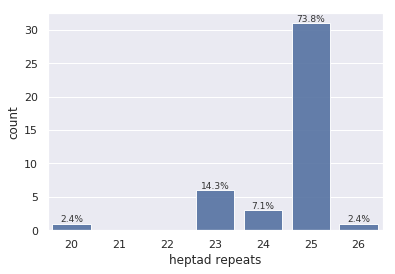

In [ ]:
%matplotlib inline 
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Want an image file of the figure saved?
saveplot = True
saveplot_fn_prefix = 'heptad_repeat_distribution'

#sns.distplot(sum_pm_df["hit_number"], kde=False, bins = max(sum_pm_df["hit_number"]));
p= sns.countplot(sum_pm_df["hit_number"],
    order = list(range(sum_pm_df.hit_number.min(),sum_pm_df.hit_number.max()+1)), 
    color="C0", alpha= 0.93)
    #palette="Blues"); # `order` to get those categories with zero 
    # counts to show up from https://stackoverflow.com/a/45359713/8508004
p.set_xlabel("heptad repeats")

#add percent above bars, based on code in middle of https://stackoverflow.com/a/33259038/8508004
ncount = len(sum_pm_df)
for pat in p.patches:
    x=pat.get_bbox().get_points()[:,0]
    y=pat.get_bbox().get_points()[1,1]
    # note that this check on the next line was necessary to add when I went back to cases where there's
    # no counts for certain categories and so `y` was coming up `nan` for for thos and causing error
    # about needing positive value for the y value; `math.isnan(y)` based on https://stackoverflow.com/a/944733/8508004
    if not math.isnan(y):
        p.annotate('{:.1f}%'.format(100.*y/(ncount)), (x.mean(), y), ha='center', va='bottom', size = 9, color='#333333')


if saveplot:
    fig = p.get_figure() #based on https://stackoverflow.com/a/39482402/8508004
    fig.savefig(saveplot_fn_prefix + '.png', bbox_inches='tight')
    fig.savefig(saveplot_fn_prefix + '.svg');

However, with the entire 1011 collection, those at the bottom can not really be seen. The next plot shows this by limiting y-axis to 103.
It should be possible to make a broken y-axis plot for this eventually but not right now as there is no automagic way. So for now will need to composite the two plots together outside.


(Note that adding percents annotations makes height of this plot look odd in the notebook cell for now.)

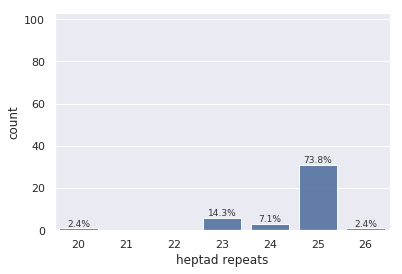

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Want an image file of the figure saved?
saveplot = True
saveplot_fn_prefix = 'heptad_repeat_distributionLIMIT103'

#sns.distplot(sum_pm_df["hit_number"], kde=False, bins = max(sum_pm_df["hit_number"]));
p= sns.countplot(sum_pm_df["hit_number"],
    order = list(range(sum_pm_df.hit_number.min(),sum_pm_df.hit_number.max()+1)), 
    color="C0", alpha= 0.93)
    #palette="Blues"); # `order` to get those categories with zero 
    # counts to show up from https://stackoverflow.com/a/45359713/8508004
p.set_xlabel("heptad repeats")
plt.ylim(0, 103)

#add percent above bars, based on code in middle of https://stackoverflow.com/a/33259038/8508004
ncount = len(sum_pm_df)
for pat in p.patches:
    x=pat.get_bbox().get_points()[:,0]
    y=pat.get_bbox().get_points()[1,1]
    # note that this check on the next line was necessary to add when I went back to cases where there's
    # no counts for certain categories and so `y` was coming up `nan` for those and causing error
    # about needing positive value for the y value; `math.isnan(y)` based on https://stackoverflow.com/a/944733/8508004
    if not math.isnan(y):
        p.annotate('{:.1f}%'.format(100.*y/(ncount)), (x.mean(), y), ha='center', va='bottom', size = 9, color='#333333')

if saveplot:
    fig = p.get_figure() #based on https://stackoverflow.com/a/39482402/8508004
    fig.savefig(saveplot_fn_prefix + '.png')
    fig.savefig(saveplot_fn_prefix + '.svg');

I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939) (or `+1` like [Hsin and Manley, 2012](https://www.ncbi.nlm.nih.gov/pubmed/23028141)); however, that is something that could be explored further.

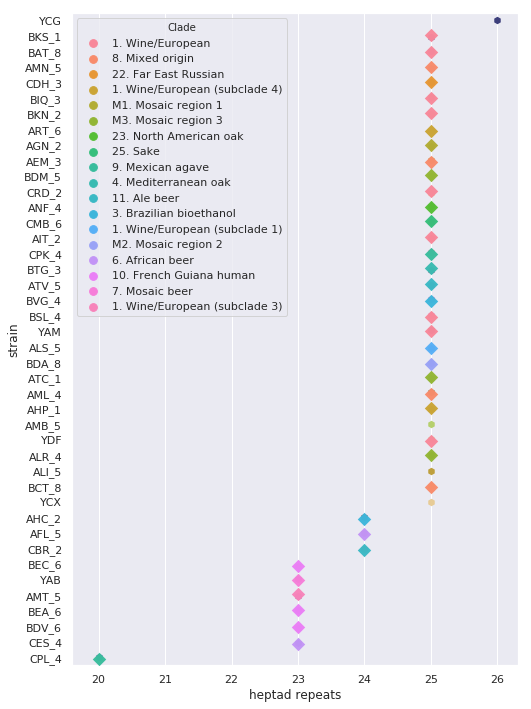

In [ ]:
%matplotlib inline 
# above line works for JupyterLab which I was developing in. Try  `%matplotlib notebook` for when in classic.

# Visualization
# This is loosely based on my past use of seaborn when making `plot_sites_position_across_chromosome.py` and related scripts.
# For example, see `GC-clusters relative mito chromosome and feature` where I ran 
# `%run plot_sites_position_across_chromosome.py GC_df_for_merging.pkl -o strand_ofGCacross_mito_chrom`

# add the strain info for listing that without chr info & add species information for coloring on that
chromosome_id_prefix = "-"
def FASTA_id_to_strain(FAid):
    '''
    use FASTA_id column value to convert to strain_id 
    and then return the strain_id
    '''
    return FAid.split(chromosome_id_prefix)[0]
sum_pm_df_for_plot = sum_pm_df.copy()
sum_pm_df_for_plot['strain'] = sum_pm_df['FASTA_id'].apply(FASTA_id_to_strain)
# sum_pm_df['species'] = sum_pm_df['FASTA_id'].apply(strain_to_species) # since need species for label plot strips
# it is easier to add species column first and then use map instead of doing both at same with one `apply`
# of a function or both separately, both with `apply` of two different function.
# sum_pm_df['species'] = sum_pm_df['strain'].apply(strain_to_species)
sum_pm_df_for_plot['species'] = 'cerevisiae'

#Want an image file of the figure saved?
saveplot = True
saveplot_fn_prefix = 'heptad_repeats_by_strain'

import matplotlib.pyplot as plt
if len(sum_pm_df) > 60:
    plt.figure(figsize=(8,232))
else:
    plt.figure(figsize=(8,12))
import seaborn as sns
sns.set()
# Simple look - Comment out everything below to the next two lines to see it again.
p = sns.stripplot(x="hit_number", y="strain", data=sum_pm_df_for_plot, marker="h", size=7.5, alpha=.98, palette="tab20b")
p = sns.stripplot(x="hit_number", y="strain", data=sum_pm_df_for_plot, marker="D", size=9.5, alpha=.98, hue="Clade")
# NOTE CANNOT JUST USE ONE WITH `hue` by 'Clase' because several don't Clades assigned in the supplemental data
# and so those left off. This overlays the two and doesn't cause artifacts when size of first maker smaller.
p.set_xlabel("heptad repeats")
#p.set_xticklabels([" ","23"," ","24", " ", "25"]) # This was much easier than all the stuff I tried for `Adjusted` look below
# and the only complaint I have with the results is that what I assume are the `minor` tick lines show up; still ended up
# needing this when added `xticks = p.xaxis.get_major_ticks()` in order to not show decimals for ones I kept
#p.set(xticks=[]) # this works to remove the ticks entirely; however, I want to keep major ticks
'''
xticks = p.xaxis.get_major_ticks() #based on https://stackoverflow.com/q/50820043/8508004
for i in range(len(xticks)):
    #print (i) # WAS FOR DEBUGGING
    keep_ticks = [1,3,5] #harcoding essentially again, but at least it works
    if i not in keep_ticks:
        xticks[i].set_visible(False)
'''
'''
# Highly Adjusted look - Comment out default look parts above. Ended up going with simple above because still couldn't get
# those with highest number of repeats with combination I could come up with.
sum_pm_df_for_plot["repeats"] = sum_pm_df_for_plot["hit_number"].astype(str) # when not here (use `x="hit_number"` in plot) or 
# tried `.astype('category')` get plotting of the 0.5 values too
sum_pm_df_for_plot.sort_values('hit_number', ascending=True, inplace=True) #resorting again was necessary when
# added `sum_pm_df["hit_number"].astype(str)` to get 'lower' to 'higher' as left to right for x-axis; otherwise
# it was putting the first rows on the left, which happened to be the 'higher' repeat values
#p = sns.catplot(x="repeats", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98) #marker size ignored in catplot?
p = sns.stripplot(x="repeats", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98)
#p = sns.stripplot(x="repeats", y="strain", hue="species", order = list(species_dict.keys()), data=sum_pm_df_for_plot, marker="D", 
#    size=10, alpha=.98) # not fond of essentially harcoding to strain order but makes more logical sense to have
    # strains with most repeats at the top of the y-axis; adding `order` makes `sort` order be ignored
p.set_xlabel("heptad repeats")
sum_pm_df_for_plot.sort_values('hit_number', ascending=False, inplace=True) #revert to descending sort for storing df;
'''
if saveplot:
    fig = p.get_figure() #based on https://stackoverflow.com/a/39482402/8508004
    fig.savefig(saveplot_fn_prefix + '.png', bbox_inches='tight')
    fig.savefig(saveplot_fn_prefix + '.svg');

(Hexagons are used for those without an assigned clade in [the supplemental data Table 1](https://www.nature.com/articles/s41586-018-0030-5) in the plot above.)

I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939) (or `+1` like [Hsin and Manley, 2012](https://www.ncbi.nlm.nih.gov/pubmed/23028141)); however, that is something that could be explored further.

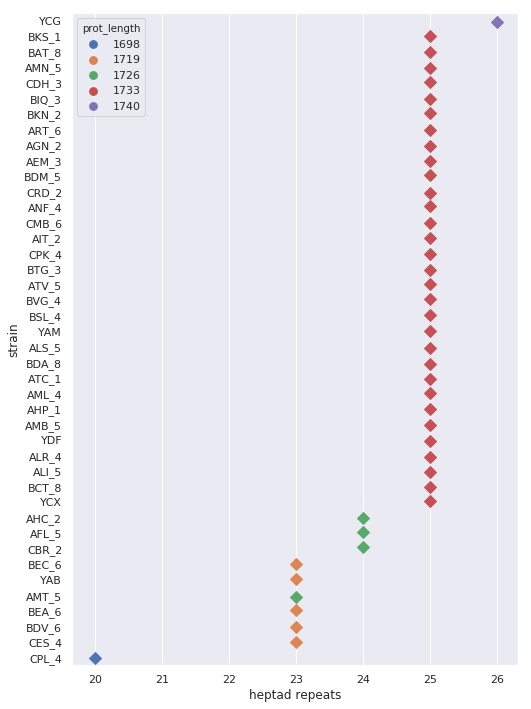

In [ ]:
%matplotlib inline 
# above line works for JupyterLab which I was developing in. Try  `%matplotlib notebook` for when in classic.

# Visualization
# This is loosely based on my past use of seaborn when making `plot_sites_position_across_chromosome.py` and related scripts.
# For example, see `GC-clusters relative mito chromosome and feature` where I ran 
# `%run plot_sites_position_across_chromosome.py GC_df_for_merging.pkl -o strand_ofGCacross_mito_chrom`

# add the strain info for listing that without chr info & add species information for coloring on that
chromosome_id_prefix = "-"
def FASTA_id_to_strain(FAid):
    '''
    use FASTA_id column value to convert to strain_id 
    and then return the strain_id
    '''
    return FAid.split(chromosome_id_prefix)[0]
sum_pm_df_for_plot = sum_pm_df.copy()
sum_pm_df_for_plot['strain'] = sum_pm_df['FASTA_id'].apply(FASTA_id_to_strain)
# sum_pm_df['species'] = sum_pm_df['FASTA_id'].apply(strain_to_species) # since need species for label plot strips
# it is easier to add species column first and then use map instead of doing both at same with one `apply`
# of a function or both separately, both with `apply` of two different function.
# sum_pm_df['species'] = sum_pm_df['strain'].apply(strain_to_species)
sum_pm_df_for_plot['species'] = 'cerevisiae'

#Want an image file of the figure saved?
saveplot = True
saveplot_fn_prefix = 'heptad_repeats_by_proteinlen'

import matplotlib.pyplot as plt
if len(sum_pm_df) > 60:
    plt.figure(figsize=(8,232))
else:
    plt.figure(figsize=(8,12))
import seaborn as sns
sns.set()
# Simple look - Comment out everything below to the next two lines to see it again.
#p = sns.stripplot(x="hit_number", y="strain", data=sum_pm_df_for_plot, marker="h", size=7.5, alpha=.98, palette="tab20b")
p = sns.stripplot(x="hit_number", y="strain", data=sum_pm_df_for_plot, marker="D", size=9.5, alpha=.98, hue="prot_length")
# NOTE CANNOT JUST USE ONE WITH `hue` by 'Clase' because several don't Clades assigned in the supplemental data
# and so those left off. This overlays the two and doesn't cause artifacts when size of first maker smaller.
p.set_xlabel("heptad repeats")
#p.set_xticklabels([" ","23"," ","24", " ", "25"]) # This was much easier than all the stuff I tried for `Adjusted` look below
# and the only complaint I have with the results is that what I assume are the `minor` tick lines show up; still ended up
# needing this when added `xticks = p.xaxis.get_major_ticks()` in order to not show decimals for ones I kept
#p.set(xticks=[]) # this works to remove the ticks entirely; however, I want to keep major ticks
'''
xticks = p.xaxis.get_major_ticks() #based on https://stackoverflow.com/q/50820043/8508004
for i in range(len(xticks)):
    #print (i) # WAS FOR DEBUGGING
    keep_ticks = [1,3,5] #harcoding essentially again, but at least it works
    if i not in keep_ticks:
        xticks[i].set_visible(False)
'''
'''
# Highly Adjusted look - Comment out default look parts above. Ended up going with simple above because still couldn't get
# those with highest number of repeats with combination I could come up with.
sum_pm_df_for_plot["repeats"] = sum_pm_df_for_plot["hit_number"].astype(str) # when not here (use `x="hit_number"` in plot) or 
# tried `.astype('category')` get plotting of the 0.5 values too
sum_pm_df_for_plot.sort_values('hit_number', ascending=True, inplace=True) #resorting again was necessary when
# added `sum_pm_df["hit_number"].astype(str)` to get 'lower' to 'higher' as left to right for x-axis; otherwise
# it was putting the first rows on the left, which happened to be the 'higher' repeat values
#p = sns.catplot(x="repeats", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98) #marker size ignored in catplot?
p = sns.stripplot(x="repeats", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98)
#p = sns.stripplot(x="repeats", y="strain", hue="species", order = list(species_dict.keys()), data=sum_pm_df_for_plot, marker="D", 
#    size=10, alpha=.98) # not fond of essentially harcoding to strain order but makes more logical sense to have
    # strains with most repeats at the top of the y-axis; adding `order` makes `sort` order be ignored
p.set_xlabel("heptad repeats")
sum_pm_df_for_plot.sort_values('hit_number', ascending=False, inplace=True) #revert to descending sort for storing df;
'''
if saveplot:
    fig = p.get_figure() #based on https://stackoverflow.com/a/39482402/8508004
    fig.savefig(saveplot_fn_prefix + '.png', bbox_inches='tight')
    fig.savefig(saveplot_fn_prefix + '.svg');

I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939) (or `+1` like [Hsin and Manley, 2012](https://www.ncbi.nlm.nih.gov/pubmed/23028141)); however, that is something that could be explored further.



## Make raw and summary data available for use elsewhere

All the raw data is there for each strain in `raw_pm_df`. For example, the next cell shows how to view the data associated with the summary table for isolate ADK_8:

In [ ]:
ADK_8_raw = raw_pm_df[raw_pm_df['FASTA_id'] == 'ADK_8-20587'].sort_values('hit_number', ascending=True).reset_index(drop=True)
ADK_8_raw 

,FASTA_id,hit_number,hit_id,start,end,strand,matching pattern,query pattern
0,ADK_8-20587,1,CTD_heptad-1,1542,1548,1,FSPTSPT,[YF]SP[TG]SP[STAGN]
1,ADK_8-20587,2,CTD_heptad-2,1549,1555,1,YSPTSPA,[YF]SP[TG]SP[STAGN]
2,ADK_8-20587,3,CTD_heptad-3,1556,1562,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
3,ADK_8-20587,4,CTD_heptad-4,1563,1569,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
4,ADK_8-20587,5,CTD_heptad-5,1570,1576,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
5,ADK_8-20587,6,CTD_heptad-6,1577,1583,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
6,ADK_8-20587,7,CTD_heptad-7,1584,1590,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
7,ADK_8-20587,8,CTD_heptad-8,1591,1597,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
8,ADK_8-20587,9,CTD_heptad-9,1598,1604,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
9,ADK_8-20587,10,CTD_heptad-10,1605,1611,1,YSPTSPS,[YF]SP[TG]SP[STAGN]


The summary and raw data will be packaged up into one file in the cell below. One of the forms will be a tabular text data ('.tsv') files that can be opened in any spreadsheet software.

In [ ]:
# save summary and raw results for use elsewhere (or use `.pkl` files for reloading the pickled dataframe into Python/pandas)
patmatch_fn_prefix = gene_name + "_orthologs_patmatch_results"
patmatchsum_fn_prefix = gene_name + "_orthologs_patmatch_results_summary"
patmatchsumFILTERED_fn_prefix = gene_name + "_orthologs_patmatch_results_summaryFILTERED"
patmatch_fn = patmatch_fn_prefix + ".tsv"
pkl_patmatch_fn = patmatch_fn_prefix + ".pkl"
patmatchsumUNF_fn = patmatchsumFILTERED_fn_prefix + ".tsv"
pklsum_patmatchUNF_fn = patmatchsumFILTERED_fn_prefix + ".pkl"
patmatchsum_fn = patmatchsum_fn_prefix + ".tsv"
pklsum_patmatch_fn = patmatchsum_fn_prefix + ".pkl"


import pandas as pd
sum_pm_df.to_pickle(pklsum_patmatch_fn)
sum_pm_df.to_csv(patmatchsum_fn, sep='\t') # keep index is default
sys.stderr.write("Text file of summary details after filtering saved as '{}'.".format(patmatchsum_fn))
sum_pm_UNFILTEREDdf.to_pickle(pklsum_patmatchUNF_fn)
sum_pm_UNFILTEREDdf.to_csv(patmatchsumUNF_fn, sep='\t') # keep index is default
sys.stderr.write("\nText file of summary details before filtering saved as '{}'.".format(patmatchsumUNF_fn))
raw_pm_df.to_pickle(pkl_patmatch_fn)
raw_pm_df.to_csv(patmatch_fn, sep='\t') # keep index is default
sys.stderr.write("\nText file of raw details saved as '{}'.".format(patmatchsum_fn))
# pack up archive dataframes
pm_dfs_list = [patmatch_fn,pkl_patmatch_fn,patmatchsumUNF_fn,pklsum_patmatchUNF_fn, patmatchsum_fn,pklsum_patmatch_fn]
archive_file_name = patmatch_fn_prefix+".tar.gz"
!tar czf {archive_file_name} {" ".join(pm_dfs_list)} # use the list for archiving command
sys.stderr.write("\nCollected pattern matching"
                 " results gathered and saved as "
                 "`{}`.".format(archive_file_name))

Text file of summary details after filtering saved as 'RPB1_orthologs_patmatch_results_summary.tsv'.
Text file of summary details before filtering saved as 'RPB1_orthologs_patmatch_results_summaryFILTERED.tsv'.
Text file of raw details saved as 'RPB1_orthologs_patmatch_results_summary.tsv'.
Collected pattern matching results gathered and saved as `RPB1_orthologs_patmatch_results.tar.gz`.

Download the tarballed archive of the files to your computer.

For now that archive doesn't include the figures generated from the plots because with a lot of strains they can get large. Download those if you want them. (Look for `saveplot_fn_prefix` settings in the code to help identify file names.)

----

In [ ]:
import time

def executeSomething():
    #code here
    print ('.')
    time.sleep(480) #60 seconds times 8 minutes

while True:
    executeSomething()

.
